# ML Project - Fall 2021
---
In this project we are going to predict the behavior of customers when cliking on an advertisements that whether they buy that product or not.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
data = pd.read_csv('train_dataset.csv')
data.head()

,Sale,SalesAmountInEuro,time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,...,product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,partner_id,user_id
0,0,-1.0,-1,2020-08-04 04:07:56,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,...,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,B69E439E41E0BEAD764ABF16D7FD96C9,-1,E3DDEB04F8AFF944B11943BB57D2F620,5E2C678F6586B67F61A377E1534E01FC
1,0,-1.0,-1,2020-08-04 01:47:40,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,...,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,404D3D9D03297504F3509032DCFA02F0,-1,E3DDEB04F8AFF944B11943BB57D2F620,E8247702C0DD294E0AE6B5B5E2F9E810
2,0,-1.0,-1,2020-08-04 16:54:31,-1,0.0,4C90FD52FC53D2C1C205844CB69575AB,FF2C446555E3822B0E0FC3406116E86D,-1,C45A9AC6D102ACAEEDF0D6F78636D84A,...,-1,-1,-1,-1,-1,2AC62132FBCFA093B9426894A4BC6278,B09E51338E0EED59C5A859B13631C370,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC 516EE9C34B839...,12E43E51784BDE3CB9E0EF6310A7D5C5,9FD001258907F541D497040C64383696
3,0,-1.0,-1,2020-08-03 20:34:28,-1,0.0,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,...,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,080614393A57816D7A655695E2DBE728,-1,E3DDEB04F8AFF944B11943BB57D2F620,225741ACF2DBB2E5948268F5D5D352E6
4,0,-1.0,-1,2020-08-03 20:54:17,1064,0.0,4C90FD52FC53D2C1C205844CB69575AB,7E56C27BFF0305E788DA55A029EC4988,-1,1B491180398E2F0390E6A588B3BCE291,...,1E629AECC2FB9BEF43331CBE8F2D7C08,341C9BD18A3277E6B104CAFC177DE796,-1,-1,-1,989EEF92F2A525DD896557425EA7C4C7,350271BAFD7C7AAF6FB1424CF3DD4827,097C90F8BF5398AC7C486804F0801DEE E09E084DB8937...,F0FD783189F55BAFC331AD347EAE6863,160A90377E54124D0BD31DB6735F0B33


# New Section

---
# 1. EDA

In this part we are going to get some insights about our data and find out what information each variable gives us. To do so we will follow bellow steps:
1. Understanding variables
2. Analyzing relationships between variables

Two columns _'SalesAmountInEuro'_ and	_'time_delay_for_conversion'_ are -1 if product has been bought and a positive number otherwise. So they are equivalent to label (Sale) and we can't use them in training.

In [7]:
data = data.drop(columns=['SalesAmountInEuro',	'time_delay_for_conversion'], errors='ignore')

Inspecting _'click_timestamp'_ column:

In [8]:
data['click_timestamp'].apply(lambda x: x.split(' ')[0]).unique()

array(['2020-08-04', '2020-08-03'], dtype=object)

So it contains only two days. We change this column to a integer value indicating number of seconds from start of the day.

In [14]:
def get_seconds(time_str):
  _, hour = time_str.split(' ')
  t = list(map(int, hour.split(':')))
  return t[0] * 3600 + t[1] * 60 + t[2]

def get_day(time_str):
  date, _ = time_str.split(' ')
  return int(date.split('-')[-1])

data = data.merge(data['click_timestamp'].apply(lambda s: pd.Series({'click_day':get_day(s), 'click_second':get_seconds(s)})), left_index=True, right_index=True)

In [16]:
data.drop(columns=['click_timestamp'], errors='ignore', inplace=True)
data.head()

,Sale,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),...,product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,partner_id,user_id,click_day,click_second
0,0,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,...,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,B69E439E41E0BEAD764ABF16D7FD96C9,-1,E3DDEB04F8AFF944B11943BB57D2F620,5E2C678F6586B67F61A377E1534E01FC,4,14876
1,0,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,...,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,404D3D9D03297504F3509032DCFA02F0,-1,E3DDEB04F8AFF944B11943BB57D2F620,E8247702C0DD294E0AE6B5B5E2F9E810,4,6460
2,0,-1,0.0,4C90FD52FC53D2C1C205844CB69575AB,FF2C446555E3822B0E0FC3406116E86D,-1,C45A9AC6D102ACAEEDF0D6F78636D84A,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC,033E492229C2222EFAA16EE8A6462D8B,CD599E5A946D00A81A875E085F7EF1E8,...,-1,-1,-1,2AC62132FBCFA093B9426894A4BC6278,B09E51338E0EED59C5A859B13631C370,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC 516EE9C34B839...,12E43E51784BDE3CB9E0EF6310A7D5C5,9FD001258907F541D497040C64383696,4,60871
3,0,-1,0.0,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,...,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,080614393A57816D7A655695E2DBE728,-1,E3DDEB04F8AFF944B11943BB57D2F620,225741ACF2DBB2E5948268F5D5D352E6,3,74068
4,0,1064,0.0,4C90FD52FC53D2C1C205844CB69575AB,7E56C27BFF0305E788DA55A029EC4988,-1,1B491180398E2F0390E6A588B3BCE291,9B57D98465FD7D5AF39448DC29E95DC8,13C26D10258053889D75D9B9CA922EC7,346AC0DECB71FFDC9114236B419D7814,...,-1,-1,-1,989EEF92F2A525DD896557425EA7C4C7,350271BAFD7C7AAF6FB1424CF3DD4827,097C90F8BF5398AC7C486804F0801DEE E09E084DB8937...,F0FD783189F55BAFC331AD347EAE6863,160A90377E54124D0BD31DB6735F0B33,3,75257


Then we continue our inspection and split columns to 'numerical' and 'categorical' to describe them.

In [22]:
target = 'Sale'
numerical_cols = ['click_second', 'click_day', 'nb_clicks_1week', 'product_price']
categorical_cols = list(set(data.columns) - set(numerical_cols) - set([target]))

In [23]:
data[numerical_cols].describe()

,click_second,click_day,nb_clicks_1week,product_price
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,44556.281060,3.574710,236.545830,10.929187
std,25540.243105,0.494389,1153.037285,65.574247
min,0.000000,3.000000,-1.000000,0.000000
25%,21209.750000,3.000000,-1.000000,0.000000
50%,47156.500000,4.000000,0.000000,0.000000
75%,66790.250000,4.000000,49.000000,0.000000
max,86399.000000,4.000000,25390.000000,3928.000000


As we can see the difference between 75% and max in _'nb_clicks_1week'_ is too much so there must exist some outlier records in this column

In [24]:
data[categorical_cols].nunique(axis=0)

device_type                4
product_id             45447
audience_id             3182
product_category(6)       89
product_category(2)      145
product_category(1)       22
product_category(5)      442
partner_id               183
product_title          27695
product_age_group          9
product_country           17
product_brand           4770
product_gender            11
user_id                96766
product_category(7)        1
product_category(4)      910
product_category(3)      699
dtype: int64

As we can see, product_category(7) contains only one value, -1. It means non of our records have product_category(7) and we can drop it.

In [29]:
data.drop(columns=['product_category(7)'], errors='ignore', inplace=True)
categorical_cols = list(set(categorical_cols).difference(['product_category(7)']))

In [38]:
data[categorical_cols].describe()

,device_type,product_id,audience_id,product_category(6),product_category(2),product_category(1),product_category(5),partner_id,product_title,product_age_group,product_country,product_brand,product_gender,user_id,product_category(4),product_category(3)
count,100000,100000,100000,100000,100000,100000,100000,100000,99739,100000,100000,100000,100000,100000,100000,100000
unique,4,45447,3182,89,145,22,442,183,27695,9,17,4770,11,96766,910,699
top,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,-1,E3DDEB04F8AFF944B11943BB57D2F620,-1,-1,57A1D462A03BD076E029CF9310C11FC5,-1,-1,953CC020FA7459BC16D81E311EDF271E,-1,-1
freq,52539,23714,71793,98832,45517,45502,92009,31077,45502,75603,38088,65800,75554,48,71222,52316


In [45]:
data[['product_id', 'product_price']].groupby('product_id').apply(lambda df: df[df['product_price'] != 0].mean())

C:\Users\MR.co\AppData\Local\Temp/ipykernel_23036/3399611891.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data[['product_id', 'product_price']].groupby('product_id').apply(lambda df: df[df['product_price'] != 0].mean())


KeyboardInterrupt: 

<AxesSubplot:ylabel='product_price'>

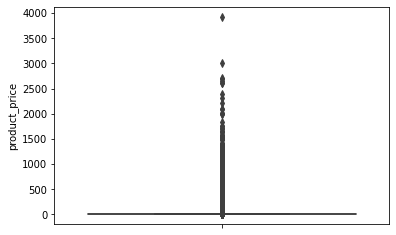

In [42]:
sns.boxplot(data=data, y='product_price')